In [1]:
import pandas as pd
import numpy as np

In [2]:
complete_df = pd.read_excel('data_okeanos.xlsx')
print(complete_df.head())

                 datum  ervaring geslacht gewichtsklasse ploeg naam zone  \
0  2018-09-11 00:00:00       1.0        M              Z   MGH  z47   AT   
1  2018-09-11 00:00:00       1.0        M              Z   MGH  z47   AT   
2  2018-09-11 00:00:00       1.0        M              Z   MGH  z47   AT   
3  2018-09-11 00:00:00       1.0        M              Z   MGH  z47   AT   
4  2018-09-11 00:00:00       1.0        M              Z   MGH  z47   AT   

  trainingype 500_split aantal_intervallen intervaltype  interval_afstand  \
0        5x5'    1:44.6                  5         tijd               NaN   
1        5x5'    1:44.7                  5         tijd               NaN   
2        5x5'    1:44.3                  5         tijd               NaN   
3        5x5'    1:44.0                  5         tijd               NaN   
4        5x5'    1:44.1                  5         tijd               NaN   

  interval_tijd interval_nummer  rust    machine spm 2k tijd   2k datum  
0     

In [3]:
def opschonen(data):
    ### Onnodige kolommen verwijderen
    complete_df = pd.read_excel(data)
    clean_col_df = complete_df.drop(columns=['datum', 'zone', 'intervaltype', 'interval_afstand', 'aantal_intervallen', 'interval_tijd', 'interval_nummer', 'rust', 'machine', 'spm'], errors='ignore')

    ### Lege strings omzetten naar NaN in de specifieke kolommen
    clean_col_df['500_split'] = clean_col_df['500_split'].replace('', pd.NA)
    clean_col_df['2k tijd'] = clean_col_df['2k tijd'].replace('', pd.NA)

    ### Alleen rijen met lege '500_split' of '2k tijd' verwijderen
    clean_row_df = clean_col_df.dropna(subset=['500_split', '2k tijd'])
    clean_row_df.dropna(how='any',inplace=True)

    ### Maak een kopie voor opschonen
    clean_df = clean_row_df.copy()
    clean_df.dropna(subset=['500_split', '2k tijd'])

    ### Komma's naar punten veranderen in ‘500_split’ en ‘2k tijd’ columns en uren veranderen naar minuten (00:01:11.11 wordt 1:11.11)
    for col in ['500_split', '2k tijd']:
        clean_df[col] = clean_df[col].astype(str).str.strip()
        clean_df[col] = clean_df[col].str.replace(',', '.', regex=False)
        clean_df[col] = clean_df[col].str.lstrip('0')

    ### Verander 'trainingype' naar 'trainingtype'
    clean_df = clean_df.rename(columns={'trainingype': 'trainingtype'})
 
    return clean_df


### de minuten veranderen naar seconden

def time_to_seconds(time_str):
    if pd.isna(time_str):
        return None
    try:
        minutes, seconds = map(float, str(time_str).split(':'))
        # print('GOOD:', time_str)
        return minutes * 60 + seconds
    except ValueError:
        # print('ERROR:', time_str)
        return None

def verander_omzetting_seconden(docu):
    docu['500_split'] = docu['500_split'].apply(time_to_seconds)
    docu['2k tijd'] = docu['2k tijd'].apply(time_to_seconds)
    return docu


In [4]:
roeien_opgeschoond = opschonen('data_okeanos.xlsx')
print(roeien_opgeschoond)

      ervaring geslacht gewichtsklasse ploeg   naam trainingtype  \
0          1.0        M              Z   MGH    z47         5x5'   
1          1.0        M              Z   MGH    z47         5x5'   
2          1.0        M              Z   MGH    z47         5x5'   
3          1.0        M              Z   MGH    z47         5x5'   
4          1.0        M              Z   MGH    z47         5x5'   
...        ...      ...            ...   ...    ...          ...   
7433       1.0        M              L   MGH  Z2522       1x2000   
7434       1.0        M              L   MGH  Z2521       1x2000   
7435       1.0        M              L   MGH  Z2520       1x2000   
7436       1.0        M              Z   MGH  Z2517       1x2000   
7437       1.0        M              Z   MGH  Z2519       1x2000   

          500_split  2k tijd   2k datum  
0            1:44.6   6:19.9 2018-12-08  
1            1:44.7   6:19.9 2018-12-08  
2            1:44.3   6:19.9 2018-12-08  
3            1:

/tmp/ipykernel_7871/1308546248.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_row_df.dropna(how='any',inplace=True)


In [5]:
dataframe_op_sec = verander_omzetting_seconden(roeien_opgeschoond)
dataframe_op_sec.dropna(inplace=True)
print(dataframe_op_sec.head())

   ervaring geslacht gewichtsklasse ploeg naam trainingtype  500_split  \
0       1.0        M              Z   MGH  z47         5x5'      104.6   
1       1.0        M              Z   MGH  z47         5x5'      104.7   
2       1.0        M              Z   MGH  z47         5x5'      104.3   
3       1.0        M              Z   MGH  z47         5x5'      104.0   
4       1.0        M              Z   MGH  z47         5x5'      104.1   

   2k tijd   2k datum  
0    379.9 2018-12-08  
1    379.9 2018-12-08  
2    379.9 2018-12-08  
3    379.9 2018-12-08  
4    379.9 2018-12-08  


In [8]:
from sklearn.preprocessing import LabelBinarizer

def omzetten_binair(df):

    ### de trainingtypes zo veranderen dat ze makkelijker te gebruiken zijn
    df['trainingtype'] = df['trainingtype'].str.replace(r"/[a-zA-Z0-9']{3,}", "", regex=True)
    df['trainingtype'] = df['trainingtype'].str.replace("HOP+3x1'r", "57'", regex=False)
    df['trainingtype'] = df['trainingtype'].str.replace(" ", "", regex=False)
    df['trainingtype'] = df['trainingtype'].str.replace("r", "", regex=False)
    df['trainingtype'] = df['trainingtype'].str.replace(r"minuutjes", "1'", regex=True)
    df['trainingtype'] = df['trainingtype'].str.replace(r'\b(?:\d+x)+1\'', "1'", regex=True)
    df['trainingtype'] = df['trainingtype'].str.replace(r'(\d+x\d+)(?!m|\')$', r'\1m', regex=True)
    df['trainingtype'] = df['trainingtype'].str.replace(r'\b(\d{4})(?!m|\')\b', r'\1m', regex=True)

    ### zet de trainingtypes om naar binaire getallen
    unique_trainingtypes = df['trainingtype'].unique()
    trainingtype_to_decimal = {trainingtype: i for i, trainingtype in enumerate(unique_trainingtypes)}
    trainingtype_mapping = {trainingtype: bin(i)[2:] for trainingtype, i in trainingtype_to_decimal.items()}
    df['binary_trainingtype'] = df['trainingtype'].map(trainingtype_mapping)

    ### zet de geslachten om naar binaire getallen
    geslacht_binarizer = LabelBinarizer()
    geslacht_binarizer.fit(df['geslacht'])
    geslacht_mapping = {str(label): bin(i)[2:] for i, label in enumerate(geslacht_binarizer.classes_)}
    df['binary_geslacht'] = df['geslacht'].map(geslacht_mapping)

    ### zet de gewichtsklasses om naar binaire getallen
    gewichtsklasse_binarizer = LabelBinarizer()
    gewichtsklasse_binarizer.fit(df['gewichtsklasse'])
    gewichtsklasse_mapping = {str(label): bin(i)[2:] for i, label in enumerate(gewichtsklasse_binarizer.classes_)}
    df['binary_gewichtsklasse'] = df['gewichtsklasse'].map(gewichtsklasse_mapping)

    ### zet de ploegnamen om naar binaire getallen
    df['ploeg'] = df['ploeg'].str.upper()
    unique_ploeg = df['ploeg'].unique()
    ploeg_to_decimal = {ploeg: i for i, ploeg in enumerate(unique_ploeg)}
    ploeg_mapping = {ploeg: bin(i)[2:] for ploeg, i in ploeg_to_decimal.items()}
    df['binary_ploeg'] = df['ploeg'].map(ploeg_mapping)

    df['ervaring'] = df['ervaring'].astype(int)

    return df, trainingtype_mapping, geslacht_mapping, gewichtsklasse_mapping, ploeg_mapping

new_dataframe, trainingtype_mapping, geslacht_mapping, gewichtsklasse_mapping, ploeg_mapping = omzetten_binair(dataframe_op_sec)

print(new_dataframe.head())
print("Trainingtype Mapping:", trainingtype_mapping)
print("Geslacht Mapping:", geslacht_mapping)
print("Gewichtsklasse Mapping:", gewichtsklasse_mapping)
print("Ploeg Mapping:", ploeg_mapping)

   ervaring geslacht gewichtsklasse ploeg naam trainingtype  500_split  \
0         1        M              Z   MGH  z47         5x5'      104.6   
1         1        M              Z   MGH  z47         5x5'      104.7   
2         1        M              Z   MGH  z47         5x5'      104.3   
3         1        M              Z   MGH  z47         5x5'      104.0   
4         1        M              Z   MGH  z47         5x5'      104.1   

   2k tijd   2k datum binary_trainingtype binary_geslacht  \
0    379.9 2018-12-08                   0               0   
1    379.9 2018-12-08                   0               0   
2    379.9 2018-12-08                   0               0   
3    379.9 2018-12-08                   0               0   
4    379.9 2018-12-08                   0               0   

  binary_gewichtsklasse binary_ploeg  
0                     1            0  
1                     1            0  
2                     1            0  
3                     1         

In [9]:
def tweek_naar_split(data):
    mask = data['500_split'] > 300
    data.loc[mask, '500_split'] = data.loc[mask, '500_split'] / 4
    return data

In [30]:
def remove_outliers(data):
  alles = tweek_naar_split(data)
  alles = alles[alles['500_split'] >= 80]
  return alles

def total_clean(data):
    
    columns_to_drop = ['geslacht', 'gewichtsklasse', 'trainingtype', 'naam', '2k datum', 'ploeg']
    cleaned_data = data.drop(columns=columns_to_drop)
    
    return cleaned_data

almost_clean_df = remove_outliers(new_dataframe)
final_df = total_clean(almost_clean_df)
print(final_df.head())
final_df.to_csv('ploeg_final_df.csv', index=False)

   ervaring  500_split  2k tijd binary_trainingtype binary_geslacht  \
0         1      104.6    379.9                   0               0   
1         1      104.7    379.9                   0               0   
2         1      104.3    379.9                   0               0   
3         1      104.0    379.9                   0               0   
4         1      104.1    379.9                   0               0   

  binary_gewichtsklasse binary_ploeg  
0                     1            0  
1                     1            0  
2                     1            0  
3                     1            0  
4                     1            0  


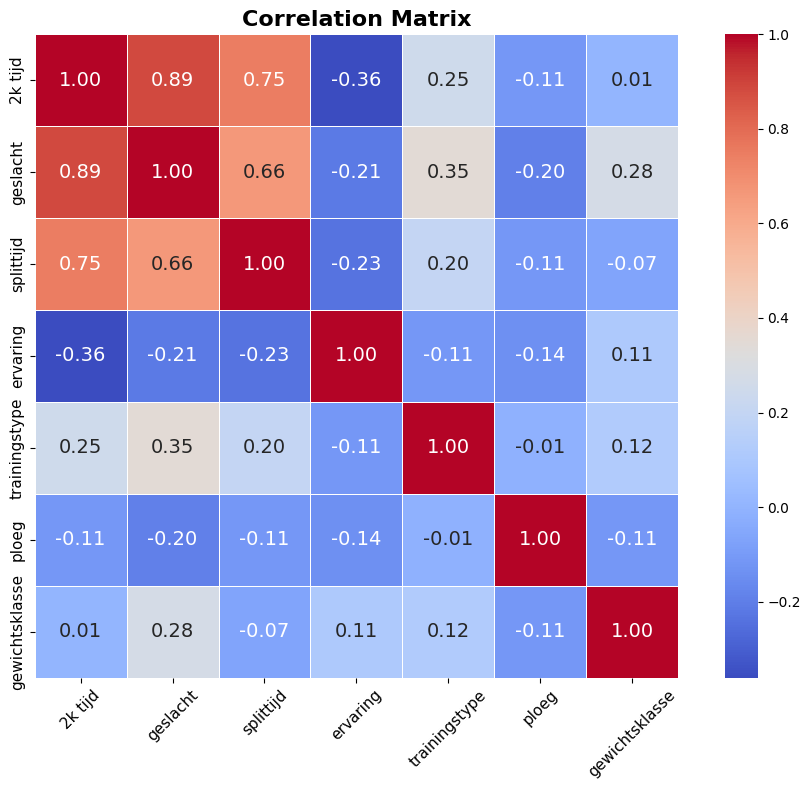

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

### Correlation plot maken
cor_final_df = final_df

cor_final_df = cor_final_df.rename(columns={
    '500_split': 'splittijd',
    'binary_trainingtype': 'trainingstype',
    'binary_geslacht': 'geslacht',
    'binary_gewichtsklasse': 'gewichtsklasse',
    'binary_ploeg': 'ploeg'
})

correlation_matrix = cor_final_df.corr()

# Sorteer op absolute correlatie met '2k tijd'
correlation_sorted = correlation_matrix['2k tijd'].abs().sort_values(ascending=False)
correlation_matrix = correlation_matrix.loc[correlation_sorted.index, correlation_sorted.index]

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True, 
    square=True,
    linewidths=0.5,
    annot_kws={"fontsize": 14}
)

plt.title("Correlation Matrix", fontsize=16, weight='bold')
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()


In [39]:
import pandas as pd

# Zorg ervoor dat binaire kolommen als strings worden behandeld
final_df[['ervaring', 'binary_trainingtype', 'binary_geslacht', 'binary_gewichtsklasse', 'binary_ploeg']] = final_df[
    ['ervaring', 'binary_trainingtype', 'binary_geslacht', 'binary_gewichtsklasse', 'binary_ploeg']
].astype(str)

# One-hot encoding van categorische kolommen
columns_to_encode = ['ervaring', 'binary_trainingtype', 'binary_geslacht', 'binary_gewichtsklasse', 'binary_ploeg']
encoded_df = pd.get_dummies(final_df, columns=columns_to_encode, drop_first=False)

# Kolomnamen aanpassen
column_renaming = {
    "binary_geslacht_0": "geslacht_M",
    "binary_geslacht_1": "geslacht_V",
    "binary_gewichtsklasse_0": "gewichtsklasse_L",
    "binary_gewichtsklasse_1": "gewichtsklasse_Z",
}

# Hernoem de kolommen als ze in de dataset staan
encoded_df = encoded_df.rename(columns={k: v for k, v in column_renaming.items() if k in encoded_df.columns})
encoded_df = encoded_df.astype(int)

# Opslaan als CSV en printen
encoded_df.to_csv('encoded_df.csv', index=False)
print(encoded_df.head())


   500_split  2k tijd  ervaring_0  ervaring_1  binary_trainingtype_0  \
0        104      379           0           1                      1   
1        104      379           0           1                      1   
2        104      379           0           1                      1   
3        104      379           0           1                      1   
4        104      379           0           1                      1   

   binary_trainingtype_1  binary_trainingtype_10  binary_trainingtype_100  \
0                      0                       0                        0   
1                      0                       0                        0   
2                      0                       0                        0   
3                      0                       0                        0   
4                      0                       0                        0   

   binary_trainingtype_1000  binary_trainingtype_10000  ...  \
0                         0              

In [24]:
### per persoon per training de gemiddelde 500_split berekenen

def gemid_split(data):
    data['year'] = pd.to_datetime(data['2k datum']).dt.year
    
    data['unique_naam'] = data['naam'] + '_' + data['year'].astype(str)

    gemid_data = data #(data.groupby(['unique_naam', 'binary_trainingtype'], as_index=False).agg({'ervaring': 'first', 'geslacht': 'first', 'gewichtsklasse': 'first', '500_split': 'mean', '2k tijd': 'first', 'binary_geslacht': 'first', 'binary_gewichtsklasse': 'first'}))

    return gemid_data

final_gemid_df = gemid_split(almost_clean_df)
print(final_gemid_df.head())
final_gemid_df.to_csv('final_gemid_df.csv', index=False)

KeyError: '2k datum'

In [65]:
# def gemid_total(data):
#     gemid_pp = (data.groupby(['unique_naam'], as_index=False).agg({'ervaring': 'first', '500_split': 'mean', '2k tijd': 'first', 'binary_geslacht': 'first', 'binary_gewichtsklasse': 'first'}))
#     return gemid_pp

# final_gemid_df = gemid_total(final_df)
# print(final_gemid_df)
# final_gemid_df.to_csv('final_gemid_df.csv', index=False)

In [75]:
### een dictionary maken van alle gegevens per persoon; dit is meer voor ons overzicht en niet nodig voor het model

import json

def dict_per_naam(data):
  naam_dict = {}

  for i in range(len(data)):
    row = data.iloc[i].to_dict()

    for key, value in row.items():
        if isinstance(value, pd.Timestamp):
            row[key] = value.strftime('%Y-%m-%d')

    name = row.pop('unique_naam')
    constants = {key: row.pop(key) for key in ['ervaring', 'binary_geslacht', 'binary_gewichtsklasse', '2k tijd']}

    if name not in naam_dict:
        naam_dict[name] = {'gegevens': constants, 'tijden': []}

    tijd_data = {key: row[key] for key in ['binary_trainingtype', '500_split']}
    naam_dict[name]['tijden'].append(tijd_data)

  print(json.dumps(naam_dict, indent=4, sort_keys=False))

  return naam_dict

data_dict = dict_per_naam(final_gemid_df)
print(len(data_dict))

{
    "z47_2018": {
        "gegevens": {
            "ervaring": 1,
            "binary_geslacht": "0",
            "binary_gewichtsklasse": "1",
            "2k tijd": 379.9
        },
        "tijden": [
            {
                "binary_trainingtype": "0",
                "500_split": 104.6
            },
            {
                "binary_trainingtype": "0",
                "500_split": 104.7
            },
            {
                "binary_trainingtype": "0",
                "500_split": 104.3
            },
            {
                "binary_trainingtype": "0",
                "500_split": 104.0
            },
            {
                "binary_trainingtype": "0",
                "500_split": 104.1
            },
            {
                "binary_trainingtype": "10",
                "500_split": 115.5
            },
            {
                "binary_trainingtype": "10",
                "500_split": 117.0
            },
            {
                "bina

In [77]:
def preprocess_data_with_trainingtype(data):
    rows = []
    
    for name, person_data in data.items():
        gegevens = person_data['gegevens']
        tijden = person_data['tijden']
        
        split_per_type = {}
        for training in tijden:
            training_type = training['binary_trainingtype']
            if training_type not in split_per_type:
                split_per_type[training_type] = []
            split_per_type[training_type].append(training['500_split'])
        
        split_features = {
            f'split_{training_type}': np.mean(splits)
            for training_type, splits in split_per_type.items()
        }
        
        row = {
            'unique_naam': name,
            'ervaring': gegevens['ervaring'],
            'binary_geslacht': gegevens['binary_geslacht'],
            'binary_gewichtsklasse': gegevens['binary_gewichtsklasse'],
            '2k_tijd': gegevens['2k tijd'],
            **split_features  # Add split features
        }
        rows.append(row)
    
    return pd.DataFrame(rows).fillna(0)

data_dict_df = preprocess_data_with_trainingtype(data_dict)
print(data_dict_df.head())

  unique_naam  ervaring binary_geslacht binary_gewichtsklasse  2k_tijd  \
0    z47_2018         1               0                     1    379.9   
1    z50_2018         1               0                     1    390.2   
2    z52_2018         1               0                     1    382.2   
3    z54_2018         1               0                     1    392.0   
4     z4_2021         1               0                     1    381.6   

   split_0    split_10     split_1    split_11  split_100  ...  split_100011  \
0   104.34  116.666667    0.000000    0.000000       0.00  ...           0.0   
1   104.74  120.900000    0.000000    0.000000       0.00  ...           0.0   
2   104.80  118.683333  120.733333    0.000000       0.00  ...           0.0   
3   108.40  119.166667  119.866667    0.000000       0.00  ...           0.0   
4     0.00  119.833333    0.000000  101.966667     103.15  ...           0.0   

   split_100111  split_101000  split_101001  split_101011  split_101010  \

In [68]:
# alles = tweek_naar_split(dataframe_op_sec)
# print(alles)
# print(len(alles))

# min_value = alles.min()
# filtered_alles = alles[alles!= min_value]

# unique_values = alles.unique()
# unique_values.sort()

# first_min = unique_values[0]
# second_min = unique_values[1]
# third_min = unique_values[2]
# fourth_min = unique_values[3]
# eighth_min = unique_values[7]

# print(first_min)
# print(second_min)
# print(third_min)
# print(fourth_min)
# print(eighth_min)

# unique_values_desc = alles.unique()
# unique_values_desc.sort()
# unique_values_desc = unique_values_desc[::-1]

# first_largest = unique_values_desc[0]
# second_largest = unique_values_desc[1]
# third_largest = unique_values_desc[2]
# eighth_largest = unique_values_desc[7]

# print(first_largest)
# print(second_largest)
# print(third_largest)
# print(eighth_largest)